## Sitting Posture Detection Training

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

### Definining the Dataset class

In [165]:
class PostureDataset(Dataset):
    def __init__(self, data, scaler=None, label_encoder=None, from_csv=True):
        """
        Args:
        - data: CSV file path or DataFrame containing the dataset.
        - scaler: StandardScaler for feature normalization.
        - label_encoder: LabelEncoder for encoding the labels (not required if already encoded).
        - from_csv: Set to True if the input is a CSV path.
        """

        self.label_encoder = label_encoder

        # Load data
        if from_csv:
            data = pd.read_csv(data)
        
        # Ensure required columns are present
        if 'class' not in data.columns:
            raise ValueError("The input data must contain a 'class' column.")
        
        # Extract features and labels
        self.X = data.drop(columns=['class']).values  # Features
        self.y = data['class'].values  # Labels (already encoded)

        # Normalize features using StandardScaler
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            self.scaler = StandardScaler()
            self.X = self.scaler.fit_transform(self.X)
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)  # Ensure labels are integers

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_class_label(self):
        """Print class encoding, actual labels"""
        class_labels = self.label_encoder.classes_

        print("\nClass Index to Label Mapping:")
        for idx, label in enumerate(class_labels):
            print(f"  {idx}: {label}")      

    def get_class_info(self):
        """Print number of samples per class."""
        class_labels = self.label_encoder.classes_
        
        print("\nNumber of Samples per Class:")
        class_counts = pd.Series(self.y.numpy()).value_counts()
        for idx, count in class_counts.items():
            print(f"  {idx} ({class_labels[idx]}): {count} samples")



### Defining the Multilayer Perceptron Model (MLP)

In [166]:
# 2. MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # Hidden layer 1
            nn.ReLU(),
            nn.Linear(128, 64),  # Hidden layer 2
            nn.ReLU(),
            nn.Linear(64, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.model(x)

### Plot training and validation results

In [167]:
def plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plots training and validation loss and accuracy side by side.

    Args:
    - train_losses (list): List of training loss values.
    - train_accuracies (list): List of training accuracy values.
    - val_losses (list): List of validation loss values.
    - val_accuracies (list): List of validation accuracy values.
    """
    # Create subplots for loss and accuracy side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Validation Loss")
    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Plot Accuracy
    axes[1].plot(train_accuracies, label="Train Accuracy")
    axes[1].plot(val_accuracies, label="Validation Accuracy")
    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

### Plot confusion matrix

In [168]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader, class_labels, device):
    """
    Generates and plots the confusion matrix.

    Args:
    - model (torch.nn.Module): Trained model.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the test set.
    - class_labels (list): List of class labels.
    - device (torch.device): Device to run the model on (CPU/GPU).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # Collect predictions and labels
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_labels)))
    
    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

### Train the model

In [169]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Print epoch stats
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Val Acc: {val_accuracies[-1]:.4f}")
    
    return train_losses, train_accuracies, val_losses, val_accuracies


### Main Script

Class Label Mapping: 

Class Index to Label Mapping:
  0: crossed_legs
  1: proper
  2: reclining
  3: slouching

------------------------------------
Training dataset:

Number of Samples per Class:
  0 (crossed_legs): 196 samples
  1 (proper): 192 samples
  3 (slouching): 183 samples
  2 (reclining): 180 samples

------------------------------------
Testing dataset:

Number of Samples per Class:
  1 (proper): 98 samples
  0 (crossed_legs): 80 samples
  2 (reclining): 73 samples
  3 (slouching): 71 samples

------------------------------------
Epoch [1/50], Train Loss: 1.2976, Train Acc: 0.4394, Val Loss: 1.2146, Val Acc: 0.4969
Epoch [2/50], Train Loss: 1.1250, Train Acc: 0.5060, Val Loss: 1.0971, Val Acc: 0.4783
Epoch [3/50], Train Loss: 1.0379, Train Acc: 0.5406, Val Loss: 1.0247, Val Acc: 0.5776
Epoch [4/50], Train Loss: 0.9635, Train Acc: 0.6245, Val Loss: 0.9715, Val Acc: 0.6118
Epoch [5/50], Train Loss: 0.8992, Train Acc: 0.6578, Val Loss: 0.9025, Val Acc: 0.6211
Epoch [6/50], T

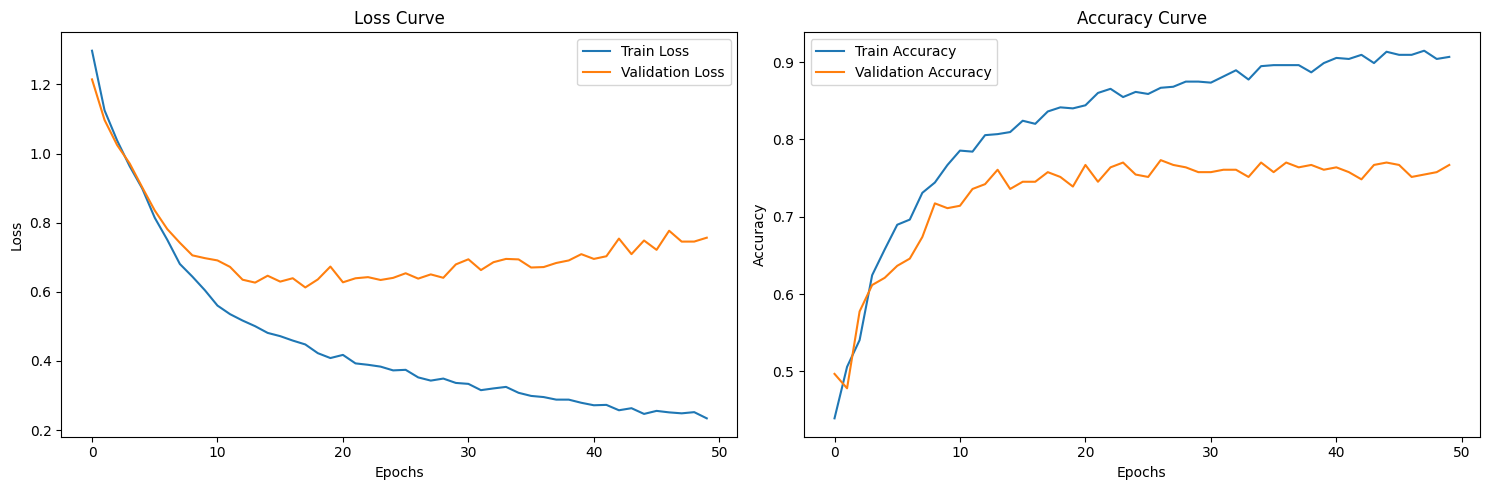

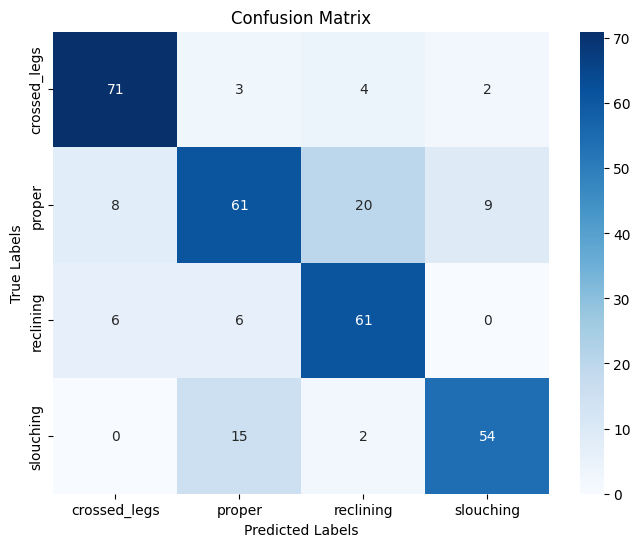

In [170]:
# Configuration
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 50
NUM_CLASSES = 4  # Crossed legs, Proper, Slouching, Reclining

if __name__ == "__main__":
    # Load and preprocess data
    csv_path = "../../datasets/vectors/augmented_xy_filtered_keypoints_vectors_mediapipe.csv"
    data = pd.read_csv(csv_path)  # Load the dataset
    
    # Encode class labels to integers using LabelEncoder
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])

    # Split the data into training and test datasets
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)

    # Standardize features
    scaler = StandardScaler()
    train_features = train_data.drop(columns=['class']).values
    scaler.fit(train_features)

    # Create datasets and loaders
    train_dataset = PostureDataset(train_data, scaler=scaler, label_encoder=label_encoder, from_csv=False)
    print("Class Label Mapping: ")
    train_dataset.get_class_label()
    print("\n------------------------------------")
    print("Training dataset:")
    train_dataset.get_class_info()
    print("\n------------------------------------")
    test_dataset = PostureDataset(test_data, scaler=scaler, label_encoder=label_encoder, from_csv=False)
    print("Testing dataset:")
    test_dataset.get_class_info()
    print("\n------------------------------------")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Model initialization
    input_size = train_features.shape[1]
    model = MLP(input_size, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model and calculate test loss
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS)

    # Plot Testing and Validation Loss and Accuracy
    plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies)

    # Plot confusion matrix
    class_labels = label_encoder.classes_  # Retrieve class labels from the encoder
    plot_confusion_matrix(model, test_loader, class_labels, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

### Export the model

In [183]:
import os
import datetime
import torch
import inspect

def save_model_with_config(model_name, base_dir):
    """
    Save the PyTorch model and its class definition to a timestamped directory.

    Args:
    - model (torch.nn.Module): The PyTorch model to save.
    - model_name (str): Name of the model file.
    - base_dir (str): Base directory to save the model.
    """
    
    # Create a timestamped directory
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(base_dir, timestamp)
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the model state dictionary
    model_path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

In [ ]:
save_model_with_config(model_name="epochs_50_lr_1e-03_acc_76.pth", base_dir="../models")

Model saved to: ../models\2024-11-24_00-06-29\epochs_50_lr_1e-03.pth
